<h1 style="font-family: 'Arial', sans-serif; color: #8E44AD; text-align: center; font-size: 2.5rem; font-weight: bold; margin-top: 30px; margin-bottom: 20px;">
  Analyser les performances sportives en utilisant des données de suivi des joueurs et des réseaux
RNN.
</h1>


In [3]:
# Import necessary libraries
from bs4 import BeautifulSoup as soup
import requests
import pandas as pd
import time
import re
from functools import reduce
from urllib.error import HTTPError
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from tabulate import tabulate

<h2 style="font-family: 'Arial', sans-serif; color: #4A90E2; text-align: center; font-size: 2rem; border-bottom: 2px solid #4A90E2; padding-bottom: 10px; margin-bottom: 20px;">
  Web Scraping for players data collection 
</h2>


In [4]:
# Function to get match links for the Premier League
def get_match_links(url):
    print('Getting player data...')
    match_links = []
    html = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    links = soup(html.content, "html.parser").find_all('a')

    # Filter list to return only needed links
    key_words_good = ['/en/matches/', 'Premier-League']
    for l in links:
        href = l.get('href', '')
        if all(x in href for x in key_words_good):
            full_link = 'https://fbref.com' + href
            if full_link not in match_links:
                match_links.append(full_link)
    return match_links

# Function to scrape player data from match links
def scrape_player_data(match_links, season):
    player_data = pd.DataFrame([])

    for count, link in enumerate(match_links):
        try:
            tables = pd.read_html(link)
            for table in tables:
                try:
                    table.columns = table.columns.droplevel()
                except Exception:
                    continue

            def get_team_1_player_data():
                data_frames = [tables[3], tables[9]]
                df = reduce(lambda left, right: pd.merge(left, right,
                    on=['Player', 'Nation', 'Age', 'Min'], how='outer'), data_frames).iloc[:-1]
                return df.assign(home=1, game_id=count)

            def get_team_2_player_data():
                data_frames = [tables[10], tables[16]]
                df = reduce(lambda left, right: pd.merge(left, right,
                    on=['Player', 'Nation', 'Age', 'Min'], how='outer'), data_frames).iloc[:-1]
                return df.assign(home=0, game_id=count)

            t1 = get_team_1_player_data()
            t2 = get_team_2_player_data()

            player_data = pd.concat([player_data, pd.concat([t1, t2]).reset_index()])

            print(f'{count + 1}/{len(match_links)} matches collected')
            player_data.to_csv(f'./data/premier_league_{season}_player_data.csv', header=True, index=False, mode='w')
        except Exception as e:
            print(f'{link}: error - {e}')
        time.sleep(3)

# Main function to control scraping
def main():
    league_id = '9'
    seasons = ['2018-2019']

    for season in seasons:
        print(f'Starting data collection for season {season}...')
        url = f'https://fbref.com/en/comps/{league_id}/{season}/schedule/{season}-Premier-League-Scores-and-Fixtures'
        match_links = get_match_links(url)
        scrape_player_data(match_links, season)
    print('Data collection complete!')

if __name__ == '__main__':
    try:
        main()
    except HTTPError as e:
        print(f'The website refused access: {e}')
        time.sleep(5)


<h2 style="font-family: 'Arial', sans-serif; color: #4A90E2; text-align: center; font-size: 2rem; border-bottom: 2px solid #4A90E2; padding-bottom: 10px; margin-bottom: 20px;">
  Data Preparation
</h2>


In [5]:
# Load the data
data = pd.read_csv("./data/premier_league_2018-2019_player_data (1).csv")
data

,index,Player,#,Nation,Pos,Age,Min,Gls,Ast,PK,...,Att_y.1,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,AvgDist,home,game_id
0,0,14 Players,NaN,NaN,NaN,NaN,990,2,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,1,Alexis Sánchez,7.0,cl CHI,"LW,LM",29-234,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,2,Andreas Pereira,15.0,br BRA,"CM,DM",22-221,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,3,David de Gea,1.0,es ESP,GK,27-276,90,0,0,0,...,5.0,100.0,60.6,23.0,0.0,0.0,0.0,9.0,1,0
4,4,Eric Bailly,3.0,ci CIV,CB,24-120,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10475,9,Mark Noble,16.0,eng ENG,CM,32-004,90,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379
10476,10,Marko Arnautović,7.0,at AUT,FW,30-023,90,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379
10477,11,Michail Antonio,30.0,jm JAM,RM,29-045,90,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379
10478,12,Pablo Zabaleta,5.0,ar ARG,RB,34-116,65,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379


In [6]:
# Rename column for readability
data = data.rename(columns={"#": "Shirt Number"})
data

,index,Player,Shirt Number,Nation,Pos,Age,Min,Gls,Ast,PK,...,Att_y.1,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,AvgDist,home,game_id
0,0,14 Players,NaN,NaN,NaN,NaN,990,2,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,1,Alexis Sánchez,7.0,cl CHI,"LW,LM",29-234,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,2,Andreas Pereira,15.0,br BRA,"CM,DM",22-221,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,3,David de Gea,1.0,es ESP,GK,27-276,90,0,0,0,...,5.0,100.0,60.6,23.0,0.0,0.0,0.0,9.0,1,0
4,4,Eric Bailly,3.0,ci CIV,CB,24-120,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10475,9,Mark Noble,16.0,eng ENG,CM,32-004,90,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379
10476,10,Marko Arnautović,7.0,at AUT,FW,30-023,90,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379
10477,11,Michail Antonio,30.0,jm JAM,RM,29-045,90,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379
10478,12,Pablo Zabaleta,5.0,ar ARG,RB,34-116,65,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379


In [7]:
# Remove invalid entries
data = data[~data['Player'].str.match(r'\d+ Players')]
data

,index,Player,Shirt Number,Nation,Pos,Age,Min,Gls,Ast,PK,...,Att_y.1,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,AvgDist,home,game_id
1,1,Alexis Sánchez,7.0,cl CHI,"LW,LM",29-234,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,2,Andreas Pereira,15.0,br BRA,"CM,DM",22-221,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,3,David de Gea,1.0,es ESP,GK,27-276,90,0,0,0,...,5.0,100.0,60.6,23.0,0.0,0.0,0.0,9.0,1,0
4,4,Eric Bailly,3.0,ci CIV,CB,24-120,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
5,5,Fred,17.0,br BRA,RM,25-158,75,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10475,9,Mark Noble,16.0,eng ENG,CM,32-004,90,2,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379
10476,10,Marko Arnautović,7.0,at AUT,FW,30-023,90,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379
10477,11,Michail Antonio,30.0,jm JAM,RM,29-045,90,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379
10478,12,Pablo Zabaleta,5.0,ar ARG,RB,34-116,65,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,379


In [8]:
# Sort and reset index
df_sorted = data.sort_values(by='Player').reset_index(drop=True)
df_sorted

,index,Player,Shirt Number,Nation,Pos,Age,Min,Gls,Ast,PK,...,Att_y.1,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,AvgDist,home,game_id
0,1,Aaron Cresswell,3.0,eng ENG,LB,29-012,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,189
1,1,Aaron Cresswell,3.0,eng ENG,LB,29-051,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,249
2,1,Aaron Cresswell,3.0,eng ENG,LB,29-056,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,252
3,1,Aaron Cresswell,3.0,eng ENG,LB,29-015,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,198
4,1,Aaron Cresswell,3.0,eng ENG,LB,29-028,90,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,13,Willian,22.0,br BRA,LW,30-087,63,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,108
9716,13,Willian,22.0,br BRA,RW,30-118,64,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,144
9717,13,Willian,22.0,br BRA,RW,30-072,72,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,80
9718,13,Xande Silva,32.0,pt POR,FW,21-289,18,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,198


In [9]:
# Check for missing values in cleaned data
nan_count = df_sorted.isna().sum()
print(nan_count)

index              0
Player             0
Shirt Number       0
Nation             0
Pos                0
Age                0
Min                0
Gls                0
Ast                0
PK                 0
PKatt              0
Sh                 0
SoT                0
CrdY               0
CrdR               0
Touches            0
Tkl                0
Int                0
Blocks             0
xG                 0
npxG               0
xAG                0
SCA                0
GCA                0
Cmp_x              0
Att_x              0
Cmp%_x           100
PrgP               0
Carries            0
PrgC               0
Att_x.1            0
Succ               0
SoTA            9020
GA              9023
Saves           9020
Save%           9048
PSxG            9019
Cmp_y           9019
Att_y           9019
Cmp%_y          9026
Att (GK)        9020
Thr             9019
Launch%         9021
AvgLen          9021
Att_y.1         9020
Launch%.1       9022
AvgLen.1        9022
Opp          

In [10]:
# Drop unnecessary columns
columns_to_drop = ['index', 'Nation', 'Shirt Number', 'Att_x.1', 'Succ', 'SoTA', 'GA', 'Saves', 'Save%', 'PSxG', 'Cmp_y',
                   'Att_y', 'Cmp%_y', 'Att (GK)', 'Thr', 'Launch%', 'AvgLen', 'Att_y.1', 'Launch%.1',
                   'AvgLen.1', 'Opp', 'Stp', 'Stp%', '#OPA', 'AvgDist', 'home', 'game_id']
df_dropped = df_sorted.drop(columns=columns_to_drop)
df_dropped

,Player,Pos,Age,Min,Gls,Ast,PK,PKatt,Sh,SoT,...,npxG,xAG,SCA,GCA,Cmp_x,Att_x,Cmp%_x,PrgP,Carries,PrgC
0,Aaron Cresswell,LB,29-012,90,0,0,0,0,0,0,...,0.0,0.1,4,1,60,79,75.9,5,42,5
1,Aaron Cresswell,LB,29-051,90,0,0,0,0,3,0,...,0.1,0.0,1,0,15,28,53.6,2,11,1
2,Aaron Cresswell,LB,29-056,90,0,0,0,0,0,0,...,0.0,0.0,3,0,38,49,77.6,5,25,3
3,Aaron Cresswell,LB,29-015,90,0,0,0,0,0,0,...,0.0,0.3,1,0,63,75,84.0,6,29,1
4,Aaron Cresswell,LB,29-028,90,0,0,0,0,1,0,...,0.1,0.0,1,0,27,39,69.2,4,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,Willian,LW,30-087,63,0,0,0,0,2,1,...,0.1,0.4,8,0,51,61,83.6,6,46,9
9716,Willian,RW,30-118,64,0,0,0,0,3,1,...,0.5,0.0,1,0,27,36,75.0,3,30,1
9717,Willian,RW,30-072,72,0,1,0,0,2,0,...,0.2,0.2,5,1,39,46,84.8,4,37,2
9718,Xande Silva,FW,21-289,18,0,0,0,0,2,0,...,0.1,0.0,2,0,3,4,75.0,0,4,0


In [11]:
# Filter players with at least 4 games and keep the first 4 games for each player
result_df = df_dropped.groupby('Player').filter(lambda x: len(x) >= 10).groupby('Player').head(10).reset_index(drop=True)
result_df

,Player,Pos,Age,Min,Gls,Ast,PK,PKatt,Sh,SoT,...,npxG,xAG,SCA,GCA,Cmp_x,Att_x,Cmp%_x,PrgP,Carries,PrgC
0,Aaron Cresswell,LB,29-012,90,0,0,0,0,0,0,...,0.0,0.1,4,1,60,79,75.9,5,42,5
1,Aaron Cresswell,LB,29-051,90,0,0,0,0,3,0,...,0.1,0.0,1,0,15,28,53.6,2,11,1
2,Aaron Cresswell,LB,29-056,90,0,0,0,0,0,0,...,0.0,0.0,3,0,38,49,77.6,5,25,3
3,Aaron Cresswell,LB,29-015,90,0,0,0,0,0,0,...,0.0,0.3,1,0,63,75,84.0,6,29,1
4,Aaron Cresswell,LB,29-028,90,0,0,0,0,1,0,...,0.1,0.0,1,0,27,39,69.2,4,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,Willian,RW,30-094,67,0,0,0,0,1,0,...,0.1,0.1,3,0,32,42,76.2,5,23,3
3666,Willian,LW,30-009,60,0,0,0,0,0,0,...,0.0,0.1,1,0,32,45,71.1,4,29,6
3667,Willian,"RW,LW",30-107,75,0,0,0,0,3,0,...,0.2,0.1,4,0,38,53,71.7,9,46,5
3668,Willian,RW,30-051,72,0,0,0,0,1,1,...,0.3,0.1,4,0,31,38,81.6,4,21,4


In [12]:
# Drop irrelevant statistics columns
columns_to_drop = ['SCA', 'GCA', 'Cmp_x', 'Att_x', 'Cmp%_x', 
                   'PK', 'PKatt']
result_df = result_df.drop(columns=columns_to_drop)
result_df

,Player,Pos,Age,Min,Gls,Ast,Sh,SoT,CrdY,CrdR,Touches,Tkl,Int,Blocks,xG,npxG,xAG,PrgP,Carries,PrgC
0,Aaron Cresswell,LB,29-012,90,0,0,0,0,0,0,99,2,2,4,0.0,0.0,0.1,5,42,5
1,Aaron Cresswell,LB,29-051,90,0,0,3,0,0,0,46,0,1,1,0.1,0.1,0.0,2,11,1
2,Aaron Cresswell,LB,29-056,90,0,0,0,0,0,0,62,3,2,2,0.0,0.0,0.0,5,25,3
3,Aaron Cresswell,LB,29-015,90,0,0,0,0,0,0,81,1,0,1,0.0,0.0,0.3,6,29,1
4,Aaron Cresswell,LB,29-028,90,0,0,1,0,0,0,48,2,3,3,0.1,0.1,0.0,4,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,Willian,RW,30-094,67,0,0,1,0,0,0,50,1,0,0,0.1,0.1,0.1,5,23,3
3666,Willian,LW,30-009,60,0,0,0,0,0,0,47,0,0,1,0.0,0.0,0.1,4,29,6
3667,Willian,"RW,LW",30-107,75,0,0,3,0,0,0,65,3,0,1,0.2,0.2,0.1,9,46,5
3668,Willian,RW,30-051,72,0,0,1,1,0,0,45,1,1,0,0.3,0.3,0.1,4,21,4


In [13]:
# Create a player_Id column by assigning unique IDs to each unique player
result_df['player_Id'] = result_df['Player'].astype('category').cat.codes

In [14]:
result_df

,Player,Pos,Age,Min,Gls,Ast,Sh,SoT,CrdY,CrdR,...,Tkl,Int,Blocks,xG,npxG,xAG,PrgP,Carries,PrgC,player_Id
0,Aaron Cresswell,LB,29-012,90,0,0,0,0,0,0,...,2,2,4,0.0,0.0,0.1,5,42,5,0
1,Aaron Cresswell,LB,29-051,90,0,0,3,0,0,0,...,0,1,1,0.1,0.1,0.0,2,11,1,0
2,Aaron Cresswell,LB,29-056,90,0,0,0,0,0,0,...,3,2,2,0.0,0.0,0.0,5,25,3,0
3,Aaron Cresswell,LB,29-015,90,0,0,0,0,0,0,...,1,0,1,0.0,0.0,0.3,6,29,1,0
4,Aaron Cresswell,LB,29-028,90,0,0,1,0,0,0,...,2,3,3,0.1,0.1,0.0,4,19,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,Willian,RW,30-094,67,0,0,1,0,0,0,...,1,0,0,0.1,0.1,0.1,5,23,3,366
3666,Willian,LW,30-009,60,0,0,0,0,0,0,...,0,0,1,0.0,0.0,0.1,4,29,6,366
3667,Willian,"RW,LW",30-107,75,0,0,3,0,0,0,...,3,0,1,0.2,0.2,0.1,9,46,5,366
3668,Willian,RW,30-051,72,0,0,1,1,0,0,...,1,1,0,0.3,0.3,0.1,4,21,4,366


In [15]:
# Get unique values of the 'Player' column
unique_players = result_df['Player'].unique()

# Print the unique values
print(unique_players)


['Aaron Cresswell' 'Aaron Lennon' 'Aaron Mooy' 'Aaron Ramsey'
 'Aaron Wan-Bissaka' 'Abdoulaye Doucouré' 'Aboubakar Kamara'
 'Adam Lallana' 'Adam Masina' 'Adam Smith' 'Adama Diakhaby' 'Adama Traoré'
 'Ademola Lookman' 'Adrian Mariappa' 'Ainsley Maitland-Niles'
 'Aleksandar Mitrović' 'Alex Iwobi' 'Alex McCarthy' 'Alex Pritchard'
 'Alexander Sørloth' 'Alexandre Lacazette' 'Alexis Sánchez' 'Alfie Mawson'
 'Alireza Jahanbakhsh' 'Alisson' 'Ander Herrera' 'Andre Gray'
 'Andre-Frank Zambo Anguissa' 'Andreas Pereira' 'Andrew Robertson'
 'Andrew Surman' 'Andros Townsend' 'André Gomes' 'André Schürrle'
 'Andy Carroll' 'Angelo Ogbonna' 'Angus Gunn' 'Anthony Knockaert'
 'Anthony Martial' 'Antonio Rüdiger' 'Aron Gunnarsson' 'Arthur Masuaku'
 'Artur Boruc' 'Ashley Barnes' 'Ashley Westwood' 'Ashley Young'
 'Asmir Begović' 'Aymeric Laporte' 'Ayoze Pérez' 'Ben Chilwell'
 'Ben Davies' 'Ben Foster' 'Ben Mee' 'Benjamin Mendy' 'Beram Kayal'
 'Bernard' 'Bernardo' 'Bernardo Silva' 'Bernd Leno' 'Bobby Reid' 'B

In [16]:
# Get unique values of the 'Player' column
unique_players = result_df['player_Id'].unique()

# Print the unique values
print(unique_players)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [17]:
# Get the count of each player_Id in the dataset
player_id_counts = result_df['player_Id'].value_counts()

# Print the counts
print(list(player_id_counts))


[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

In [18]:
all(player_id_counts == 10)

True

In [19]:
# Rename columns for clarity
result_df = result_df.rename(columns={
    "Pos": "Position", 'Min': "Minutes played", "Gls": "Goals scored", 'Ast': "Assists", 
    "Sh": "Total Shots", "SoT": "Total Shots on Target", "CrdY": "Yellow Cards", 
    "CrdR": "Red Cards", "Tkl": "Total tackles", "Int": "Total interceptions", 
    "xG": "Expected goals scored", "npxG": "Expected goals scored without penalty kicks",
    "xAG": "Expected assists", "PrgP": "Progressive passes", "PrgC": "Progressive carries"
})

In [20]:
result_df

,Player,Position,Age,Minutes played,Goals scored,Assists,Total Shots,Total Shots on Target,Yellow Cards,Red Cards,...,Total tackles,Total interceptions,Blocks,Expected goals scored,Expected goals scored without penalty kicks,Expected assists,Progressive passes,Carries,Progressive carries,player_Id
0,Aaron Cresswell,LB,29-012,90,0,0,0,0,0,0,...,2,2,4,0.0,0.0,0.1,5,42,5,0
1,Aaron Cresswell,LB,29-051,90,0,0,3,0,0,0,...,0,1,1,0.1,0.1,0.0,2,11,1,0
2,Aaron Cresswell,LB,29-056,90,0,0,0,0,0,0,...,3,2,2,0.0,0.0,0.0,5,25,3,0
3,Aaron Cresswell,LB,29-015,90,0,0,0,0,0,0,...,1,0,1,0.0,0.0,0.3,6,29,1,0
4,Aaron Cresswell,LB,29-028,90,0,0,1,0,0,0,...,2,3,3,0.1,0.1,0.0,4,19,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,Willian,RW,30-094,67,0,0,1,0,0,0,...,1,0,0,0.1,0.1,0.1,5,23,3,366
3666,Willian,LW,30-009,60,0,0,0,0,0,0,...,0,0,1,0.0,0.0,0.1,4,29,6,366
3667,Willian,"RW,LW",30-107,75,0,0,3,0,0,0,...,3,0,1,0.2,0.2,0.1,9,46,5,366
3668,Willian,RW,30-051,72,0,0,1,1,0,0,...,1,1,0,0.3,0.3,0.1,4,21,4,366


In [21]:
# Get the count of each player_Id in the dataset
player_positions = result_df['Position'].value_counts()

In [22]:
player_positions

Position
CB          593
FW          519
CM          319
RB          248
LB          245
           ... 
WB,LB,LM      1
WB,LW         1
FW,AM,LM      1
AM,RM,RW      1
RW,RM,LW      1
Name: count, Length: 156, dtype: int64

In [23]:
# Check for missing values in cleaned data
nan_count = result_df.isna().sum()
print(nan_count)

Player                                         0
Position                                       0
Age                                            0
Minutes played                                 0
Goals scored                                   0
Assists                                        0
Total Shots                                    0
Total Shots on Target                          0
Yellow Cards                                   0
Red Cards                                      0
Touches                                        0
Total tackles                                  0
Total interceptions                            0
Blocks                                         0
Expected goals scored                          0
Expected goals scored without penalty kicks    0
Expected assists                               0
Progressive passes                             0
Carries                                        0
Progressive carries                            0
player_Id           

In [24]:
result_df

,Player,Position,Age,Minutes played,Goals scored,Assists,Total Shots,Total Shots on Target,Yellow Cards,Red Cards,...,Total tackles,Total interceptions,Blocks,Expected goals scored,Expected goals scored without penalty kicks,Expected assists,Progressive passes,Carries,Progressive carries,player_Id
0,Aaron Cresswell,LB,29-012,90,0,0,0,0,0,0,...,2,2,4,0.0,0.0,0.1,5,42,5,0
1,Aaron Cresswell,LB,29-051,90,0,0,3,0,0,0,...,0,1,1,0.1,0.1,0.0,2,11,1,0
2,Aaron Cresswell,LB,29-056,90,0,0,0,0,0,0,...,3,2,2,0.0,0.0,0.0,5,25,3,0
3,Aaron Cresswell,LB,29-015,90,0,0,0,0,0,0,...,1,0,1,0.0,0.0,0.3,6,29,1,0
4,Aaron Cresswell,LB,29-028,90,0,0,1,0,0,0,...,2,3,3,0.1,0.1,0.0,4,19,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,Willian,RW,30-094,67,0,0,1,0,0,0,...,1,0,0,0.1,0.1,0.1,5,23,3,366
3666,Willian,LW,30-009,60,0,0,0,0,0,0,...,0,0,1,0.0,0.0,0.1,4,29,6,366
3667,Willian,"RW,LW",30-107,75,0,0,3,0,0,0,...,3,0,1,0.2,0.2,0.1,9,46,5,366
3668,Willian,RW,30-051,72,0,0,1,1,0,0,...,1,1,0,0.3,0.3,0.1,4,21,4,366


In [25]:
# Convert 'Age' column to numeric values
result_df['Age'] = result_df['Age'].str.extract('(\d+)').astype(float)
result_df

,Player,Position,Age,Minutes played,Goals scored,Assists,Total Shots,Total Shots on Target,Yellow Cards,Red Cards,...,Total tackles,Total interceptions,Blocks,Expected goals scored,Expected goals scored without penalty kicks,Expected assists,Progressive passes,Carries,Progressive carries,player_Id
0,Aaron Cresswell,LB,29.0,90,0,0,0,0,0,0,...,2,2,4,0.0,0.0,0.1,5,42,5,0
1,Aaron Cresswell,LB,29.0,90,0,0,3,0,0,0,...,0,1,1,0.1,0.1,0.0,2,11,1,0
2,Aaron Cresswell,LB,29.0,90,0,0,0,0,0,0,...,3,2,2,0.0,0.0,0.0,5,25,3,0
3,Aaron Cresswell,LB,29.0,90,0,0,0,0,0,0,...,1,0,1,0.0,0.0,0.3,6,29,1,0
4,Aaron Cresswell,LB,29.0,90,0,0,1,0,0,0,...,2,3,3,0.1,0.1,0.0,4,19,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,Willian,RW,30.0,67,0,0,1,0,0,0,...,1,0,0,0.1,0.1,0.1,5,23,3,366
3666,Willian,LW,30.0,60,0,0,0,0,0,0,...,0,0,1,0.0,0.0,0.1,4,29,6,366
3667,Willian,"RW,LW",30.0,75,0,0,3,0,0,0,...,3,0,1,0.2,0.2,0.1,9,46,5,366
3668,Willian,RW,30.0,72,0,0,1,1,0,0,...,1,1,0,0.3,0.3,0.1,4,21,4,366


In [67]:
#Prepare data for modeling
grouped_data = result_df.groupby('Player')

In [68]:
# Initialize lists for features (X) and target (y)
X, y = [], []

In [69]:
# Loop through each player to prepare features and target
X, y = [], []
for player, group in grouped_data:
    if len(group) >= 10:  # Ensure there are at least 10 games for the player
        # Extract features for the first 9 games
        features = group[['Minutes played', 'Total Shots', 'Total Shots on Target', 'Touches', 
                           'Expected assists', 'Progressive passes', 'Progressive carries']].iloc[:9].values
        
        # Reshape features to represent 9 games, each with the selected stats
        features = features.reshape((9, -1))  # Shape: (9 games, n_features)
        
        # Define target: Goals scored in the 10th game
        target = group['Goals scored'].iloc[9]  # The target is the goals scored in game 10
        
        # Append the feature sequence and the target
        X.append(features)
        y.append(target)

# Convert X and y into numpy arrays
X = np.array(X)  # Shape will be (n_players, 9, n_features)
y = np.array(y)  # Shape will be (n_players,)


In [70]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale the features - fit the scaler only on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape[0], X_train.shape[1], -1)

# Use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape[0], X_test.shape[1], -1)

<h2 style="font-family: 'Arial', sans-serif; color: #4A90E2; text-align: center; font-size: 2rem; border-bottom: 2px solid #4A90E2; padding-bottom: 10px; margin-bottom: 20px;">
  Model Training
</h2>

<h3>The approach used in this model involves leveraging the data from ten consecutive games for each player. Specifically, the first nine games are utilized as the training dataset to build a predictive model, which will then forecast the number of goals the player is expected to score in the tenth game. This method ensures that the model learns patterns from recent performance and makes predictions based on that historical data.</h3>


In [71]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), activation='relu'))
model.add(Dense(1, activation='linear'))

c:\Users\user\OneDrive\Bureau\SDIA\Machine-Learning\Players-Performance-Analysis\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [72]:
# Compile and train the model
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=100, batch_size=4)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1331
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0633
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0350
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102
Epoch 12/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147
Epoch 13/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082  
Epoch 14/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 15/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Ep

In [73]:
# Evaluate the model
loss = model.evaluate(X_train_scaled, y_train)
print(f"Loss: {loss}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040  
Loss: 0.005533277988433838


In [74]:
# Make predictions and compare with actual values
predictions = model.predict(X_train_scaled)
predictions

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[ 1.30966995e-02],
       [ 2.84390096e-02],
       [ 1.56898890e-02],
       [ 7.49340132e-02],
       [-3.08810081e-02],
       [ 5.02072573e-02],
       [ 3.71371806e-02],
       [ 5.04267775e-03],
       [ 5.00537641e-03],
       [ 4.96153012e-02],
       [ 1.46651994e-02],
       [ 5.73451594e-02],
       [ 1.29227620e-02],
       [ 1.19032729e-02],
       [ 1.76799484e-03],
       [ 3.09308935e-02],
       [ 8.38166289e-03],
       [-6.17731363e-03],
       [ 4.75265160e-02],
       [-2.55535785e-02],
       [-1.45431068e-02],
       [-4.34929878e-02],
       [ 6.44847378e-02],
       [ 2.74311025e-02],
       [ 5.63585199e-03],
       [ 1.69992875e-02],
       [-5.68951219e-02],
       [-9.12748091e-03],
       [-1.17583778e-02],
       [-2.49137674e-02],
       [ 2.98883300e-02],
       [ 2.63801906e-02],
       [-7.88880512e-04],
       [ 7.42371619e-01],
       [ 5.90865389e-02],
       [ 6.29757270e-02],
       [-1.95064824e-02],
       [ 7.96842054e-02],
       [ 6.7

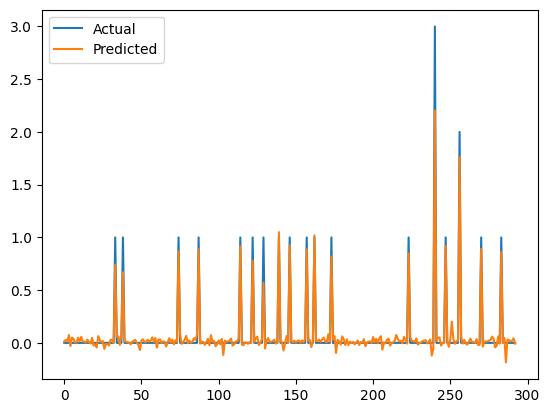

In [76]:
plt.plot(y_train, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [77]:
# Make predictions and compare with actual values
predictions = model.predict(X_test_scaled)
predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[ 0.11198465],
       [-0.04134137],
       [ 0.0142601 ],
       [ 0.00428819],
       [ 0.1788534 ],
       [ 0.13745558],
       [-0.11443585],
       [ 0.09504265],
       [ 0.5706129 ],
       [ 0.12202047],
       [ 0.01088412],
       [ 0.32594618],
       [-0.00160727],
       [ 0.04768018],
       [ 0.21204667],
       [ 0.03419022],
       [-0.08524025],
       [-0.01807388],
       [ 0.07064602],
       [-0.06232542],
       [ 0.05562672],
       [-0.04494581],
       [ 0.07894485],
       [ 0.00724013],
       [ 0.13766062],
       [ 0.0420722 ],
       [ 0.03441474],
       [ 0.05118458],
       [ 0.12003319],
       [-0.03651613],
       [ 0.01645204],
       [ 0.13422337],
       [-0.07649092],
       [-0.07094577],
       [ 0.2103716 ],
       [-0.01475537],
       [ 0.02139796],
       [ 0.00600751],
       [ 0.03480542],
       [ 0.02650515],
       [ 0.06136466],
       [ 0.02458701],
       [-0.00175778],
       [-0.02714409],
       [ 0.1572497 ],
       [ 0

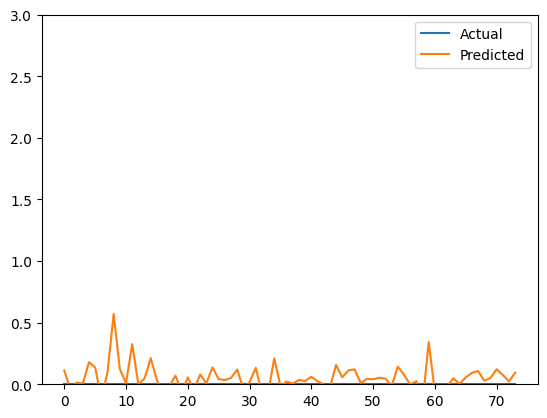

In [82]:
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.ylim(0, 3)
plt.legend()
plt.show()


<h2 style="font-family: 'Arial', sans-serif; color: #4A90E2; text-align: center; font-size: 2rem; border-bottom: 2px solid #4A90E2; padding-bottom: 10px; margin-bottom: 20px;">
  Conclusion
</h2>

<p>Based on the data I was able to gather through web scraping, despite the limitations posed by the server blocking my requests, I was able to make significant progress in training an RNN model. The dataset provided valuable insights into players past performances, including metrics such as minutes played, shots, touches, expected assists, and progressive carries. These features helped the RNN learn patterns from the players' historical performance.

By training the model on this data, the RNN has demonstrated its ability to predict players' future performance, specifically their goals scored in subsequent matches. While the dataset was limited, the model still effectively captured key trends and relationships between past performance and future outcomes. This process illustrates the power of machine learning, and demonstrates the potential of RNNs in sports analytics to predict player performance based on historical data.</p>